In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
!cp drive/MyDrive/DNN/HubbardNet_gpu.py .
!cp drive/MyDrive/DNN/matrix_element.py .
!pip install matplotlib==3.2.2
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base

In [3]:
import time 
import torch
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

from HubbardNet_gpu import *
import matrix_element as me

from os import path
import os

In [4]:
# Go to Edit -> Notebook Settings and select "GPU" from the hardware accelerator dropdown. 
# If this is on, GPU is enabled by default

use_gpu = True

# Check to see if gpu is available. If it is, use it else use the cpu
if torch.cuda.is_available() and use_gpu:
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print('Using GPU')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.DoubleTensor')
    print('Using CPU')


Using GPU


In [5]:
N_list = [3]
N = N_list[0]
model_list = []

M = 5
w = M
h = int(M/w)
pbc = False

for (n_idx, N) in enumerate(N_list): 
    O = N
    
    model = me.Bose_Hubbard(N, O, w=w, h=h, M=M, pbc=pbc)
    model_list.append(model)
    
print("The size of the Hamiltonian is {}".format(model.tot_states))

t = 1 
U_max = 5
V = 0
U_list_all = np.arange(1, U_max+1, .5)
mu_list_all = np.linspace(0, 10, 5)
mu_list_all = np.array([0.])


The size of the Hamiltonian is 35


In [6]:
from tqdm import tqdm

## NN

S = 50 # number of sample of the MH sampler
init = 1 # the first state to sample in Metropolis Hastings (has nothing to do with the optimizer!)

# Network parameters
D_hid = 400 # the number ofneurons in the hidden layer
lr = 0.01 # learning rate 
epochs = 70000
loss_diff = 1e-6
grad_cut = 1e-6
# S = 100 # number of samples for MH
num = 5
check_point = 100 # print out the energy every X points
use_sampler = False # for now, only support ground state (not working anyway)

# Model parameters
U_train = np.ones(3)*2
t_train = 1.

U_train = np.array([2.])
U_train = np.linspace(2,5,4)
mu_train = np.zeros_like(U_train)

min_state = model_list[0].tot_states-1
max_state = model_list[0].tot_states
n_excited = max_state - 1

# GS = np.zeros( (len(U_list_all), len(mu_list_all), len(N_list) ))
# ES = np.zeros( (int(n_excited), len(U_list_all), len(mu_list_all), len(N_list) ))

# paths to save and load weights 
fpath = '/content/drive/MyDrive/DNN/weights_L2_1e-4_400_Uperturb_0.01/'


t0 = time.time()

loss_all = [] 
penalty_all = []
nn = []

# filepath for excited states
fname = fpath + "/weights_M{}N{}_V{}_Umax{}_Umin{}_L5_D{}".format(M,N,V,np.max(U_train),np.min(U_train),D_hid)


In [7]:
def call_NN(lr, n_excited):
    if n_excited: 
        if n_excited == 1 :
            load_states_indv = [0]
        else:
            load_states_indv = range(1, n_excited)
        gs_flag = False
        es_flag = True
        
    else: # ground states
        load_states_indv = [0]
        gs_flag = True
        es_flag = False
    
    load_states = np.max(load_states_indv)  # total number of states being fixed 
  
    params = {'D_hid': D_hid, 
              'step_size': lr, 
              'max_iteration':epochs,
              'check_point': check_point,
              'loss_diff': loss_diff, 
              'steps': 10000, # reset learning every N steps
              'loss_check_steps': 50, # check the local every N steps
              'grad_cut': grad_cut,  # stopping condition in the total gradient 
              'weight_init': False, 
              'zero_bias': False, 
              'gs_epochs': 1000, # the maximum number of steps to minimize the ground state
              'gs_flag': gs_flag, # ground state only
              'es_flag': es_flag,  # excited state only
              'regularization': True, 
              'load_states': load_states, # the number of states loaded 
              'load_states_indv': load_states_indv, 
              'rand_steps': 5000, 
              'load_weights_from_previous_state': False, # randomize the projection every N steps
              'use_gpu': use_gpu, 
              'weight_decay': 1e-4,
              'perturb_amp': 0.01, 
              'dropout': 0.0}
  
    print("Begin optimizing for state {}".format(n_excited))
  
    fc1, Loss_history, dot_history, all_E_list = train_NN(model_list, N_list, mu_train, U_train, t_train, V, S, params, fname, \
                                              use_sampler=use_sampler, init=init, loadweights=False,\
                                              fname_load=fname, n_excited=n_excited)
    
    return fc1, Loss_history, dot_history

lr_init = np.array([0.01])


for n_excited in tqdm(range(min_state, max_state)):
    
    fc1_tmp = []
    Loss_tmp = []
    dot_tmp = []
    loss_min = []
    for lr_idx, lr in enumerate(lr_init): 
        
        fc1, Loss_history, dot_history = call_NN(lr, n_excited)
        fc1_tmp.append(fc1)
        Loss_tmp.append(Loss_history)
        dot_tmp.append(dot_history)
        loss_min.append(np.min(Loss_history))
        print(loss_min)
     
    if len(lr_init) > 1:
        # Need to do new runs, no convergence
        # otherwise, no need to do anything, can just append fc1 
        if np.abs(loss_min[0] - loss_min[1]) > 1e-3:
            print("Not converged. Need to rerun with different learning rates.") 
            lr_list = np.arange(1, 10) * 0.01
            lr_list = lr_list[(lr_list != lr_init[0]) & (lr_list != lr_init[1])]
            
            for lr_idx, lr in enumerate(lr_init): 
                fc1, Loss_history, dot_history = call_NN(lr, n_excited)
                fc1_tmp.append(fc1)
                Loss_tmp.append(Loss_history)
                dot_tmp.append(dot_history)
                loss_min.append(np.min(Loss_history))

            # choose the minimum energy value
            idx = np.argsort(loss_min)
            fc1 = fc1_tmp[idx[0]]
            Loss_history = Loss_tmp[idx[0]]
            dot_history = dot_tmp[idx[0]] 
            
            if np.std(loss_min[idx[0:3]]) > 1e-4: 
                print("Not converged!!")
    
    nn.append(fc1)
    loss_all.append(Loss_history)
    penalty_all.append(dot_history)
    
    print("=================================")

tf = time.time()
print("Training time = {} seconds.".format(tf-t0))

  0%|          | 0/1 [00:00<?, ?it/s]

Begin optimizing for state 34
0.01
Loading existing weights...


/content/HubbardNet_gpu.py:416: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  all_states = torch.tensor([model_list[k].all_states[i].reshape((1,-1))


Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading weights for ground states previous 34 states


/content/HubbardNet_gpu.py:727: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  H_list.append(torch.tensor(H, dtype=torch.double))
/content/HubbardNet_gpu.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = torch.tensor(H).double()
/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Iteration 0, current learning rate 0.01, loss 11.678810119628906, total gradient -8.843792059606788e-09
Iteration 100, current learning rate 0.009997483708783913, loss 11.678810119628906, total gradient -1.7483963057524033e-08
11.67881
Minimum loss reached


100%|██████████| 1/1 [02:18<00:00, 138.16s/it]

Reset scheduler
Reset scheduler
Reset scheduler
Reset scheduler
Reset scheduler
Reset scheduler
Reset scheduler
[11.67881]
Training time = 138.20138597488403 seconds.


<ipython-input-14-1281203d8678>:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


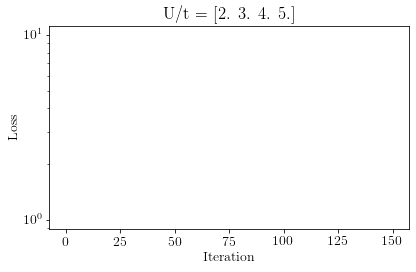

In [14]:
plt.rcParams.update({'font.size': 20})
plt.rc('text',usetex=True)
#font = {'family':'serif','size':16}
font = {'family':'serif','size':25, 'serif': ['computer modern roman']}
plt.rc('font',**font)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']

plt.rcParams.update({'font.size': 14})
rc('text', usetex=True)
for i in range(len(nn)): 
    Loss_history = loss_all[i]
    Loss_history = np.array(Loss_history)
    
    fig,ax=plt.subplots()
    ax.plot(Loss_history - np.min(Loss_history), '-', label='loss')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("U/t = {}".format(U_train))
    ax.set_yscale('log')
    
    
    # ax.plot(dot_history, '-', label='regularization')
    ax.set_xlabel("Iteration")
    # ax.set_ylabel("Dot product")
    ax.set_title("U/t = {}".format(U_train))
    # ax.legend()
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/DNN/figures/loss_M{}N{}n{}.pdf'.format(M,N,range(min_state, max_state)[i]), format='pdf')
    plt.show()
    

In [12]:
E_all = np.zeros(( len(U_train), model.tot_states) )
# check solution 
for (i, U) in enumerate(U_train):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[i])
    evals, evecs = np.linalg.eig(H)
    idx = np.argsort(evals)
    evecs = evecs[:,idx]
    evals = evals[idx]
    E_all[i] = evals

# for i in range(min_state, max_state): 
#     print(E_all[:,i].mean())

<ipython-input-12-a8bf3ce00c54>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  E_all[i] = evals


In [13]:
from HubbardNet_gpu import *

# n_excited=20
torch.cuda.empty_cache()

with torch.no_grad():
    load_states_indv = range(1, n_excited)
    n_excited = model_list[0].tot_states-1
    fc_gs = load_weights(fname + "gs", M, D_hid)

    fc2 = [load_weights(fname + "n" + str(x), M, D_hid) for x in load_states_indv]

    fc1 = load_weights(fname + "n" + str(load_states_indv[-1]+1), M, D_hid) 

    _, wf_gs = wf_e_calc(model_list[0], N_list[0], U_train, mu_train, t, V, 0, 0, fc_gs, use_gpu=True)


    E_train, wf = wf_e_calc(model_list[0], N_list[0], U_train, mu_train, t, V, n_excited, load_states_indv, fc_gs, fc1=fc1, fc2=fc2, use_gpu=True)

Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...
Loading existing weights...


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


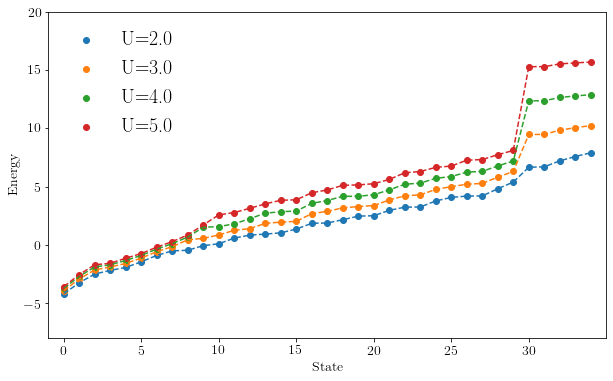

In [15]:

arr = [] 
n_excited = model_list[0].tot_states-1
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for (i, U) in enumerate(U_train):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx = np.argsort(vals)
    vals = np.sort(vals)
    # print(vals[0:n_excited+1])
    arr.append(np.min(vals))
    
    ax.plot(range(n_excited+1), vals[0:n_excited+1], '--')
    ax.scatter(range(n_excited+1), E_train[i, :], label='U={}'.format(U_train[i]))

ax.set_ylabel('Energy')
ax.set_xlabel('State')
ax.legend(frameon=False, loc=2,prop={'size': 20})
# ax.set_xticks( range(0,n_excited+1,5) )
ax.set_xticks( range(0,35,5) )
ax.set_xlim((-1,35))
ax.set_ylim((-8, 20))
plt.savefig("/content/drive/MyDrive/DNN/figures/energy_M{}N{}.pdf".format(M,N), format='pdf')
plt.show()


In [ ]:
# n_excited=34
# load_states_indv

<ipython-input-24-f5e0f486a2e2>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  vals_all[:,i] = np.sort(vals)


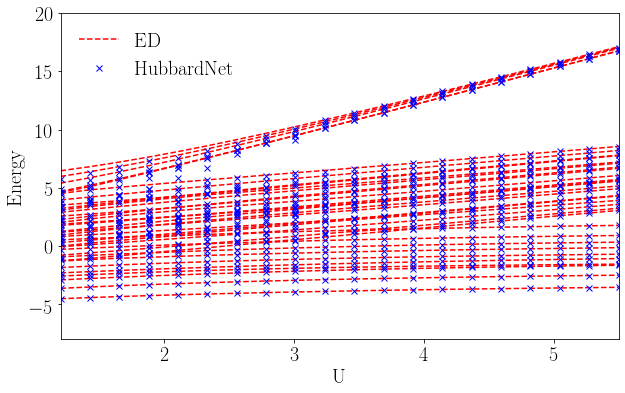

In [24]:
plt.rcParams.update({'font.size': 20})

U_test = np.linspace(1.2, 5.5, 20)
mu_test = np.zeros_like(U_test)
max_state = model.tot_states 
load_states_indv = range(1, n_excited)

E_test, wf_test = wf_e_calc(model_list[0], N_list[0], U_test, mu_test, t, V, n_excited, load_states_indv, fc_gs, fc1=fc1, fc2=fc2, use_gpu=True)

# check the constraint due to the eigenvalue equation

# ground truth 
vals_all = np.zeros( (model.tot_states, len(U_test)))
for (i,U) in enumerate(U_test):
    
    _, _, H = model.H_Bose_Hubbard(t, U, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_all[:,i] = np.sort(vals)


fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(U_test, vals_all.T[:,0], 'r--', label='ED')
ax.plot(U_test, vals_all.T[:,1::], 'r--')


for s in range(min_state,max_state):     
    for (i,U) in enumerate(U_test):
        _, _, H = model.H_Bose_Hubbard(t, U, mu=mu_train[0])
        wf_here = wf_test[i*model.tot_states:(i+1)*model.tot_states,s].squeeze().double()
        term1 = torch.mv(torch.tensor(H).double(), wf_here.double())
        term2 = E_test[i, s] * wf_here 
        # print(U, s, torch.sum(term1-term2).cpu().detach().numpy())

    # plt.legend(frameon=False)
    # plt.show()


ax.plot(U_test, E_test[:,0], 'bx', label='HubbardNet')
ax.plot(U_test, E_test[:,1::], 'bx')
ax.set_xlabel('U')
ax.set_ylabel('Energy')
ax.set_ylim((-8,20))
ax.set_xticks(range(0,6))
ax.set_xlim((np.min(U_test),np.max(U_test)))
plt.legend(frameon=False,prop={'size': 20})
plt.savefig("/content/drive/MyDrive/DNN/figures/spectrum_M{}N{}.pdf".format(M,N), format='pdf')
plt.show()


<ipython-input-38-4c1840c39881>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  vals_all[:,i] = vals
<ipython-input-38-4c1840c39881>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  vecs_all[:,:,i] = vecs


4


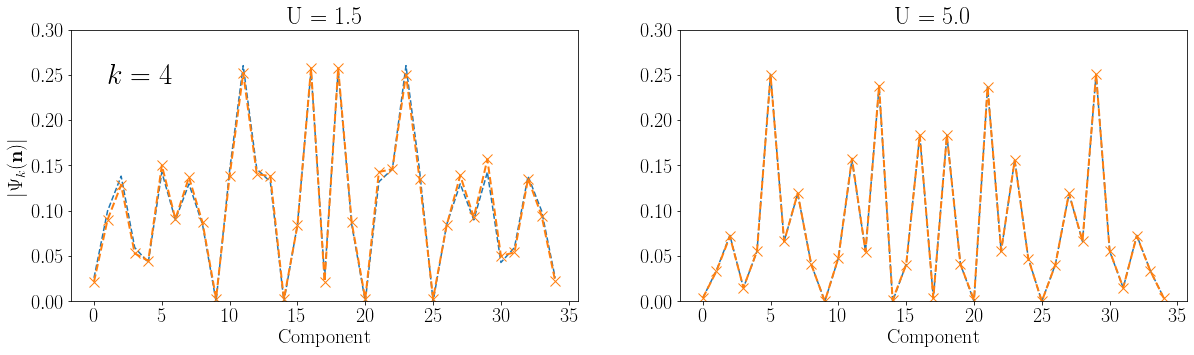

15


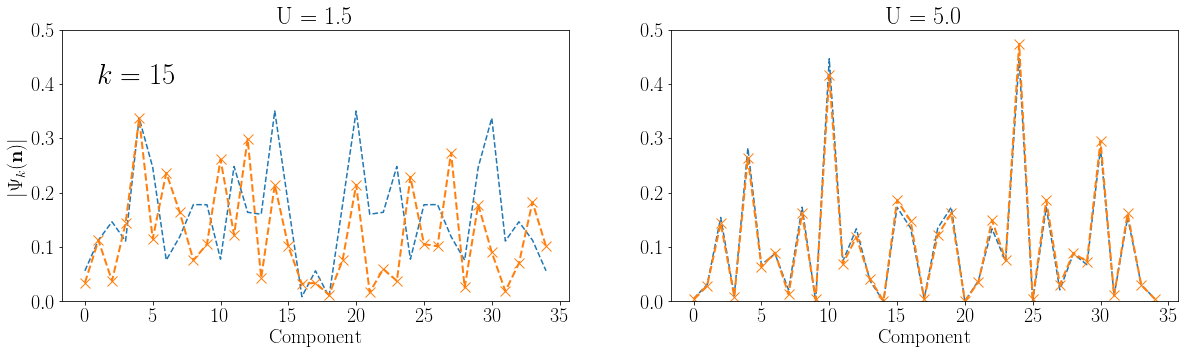

30


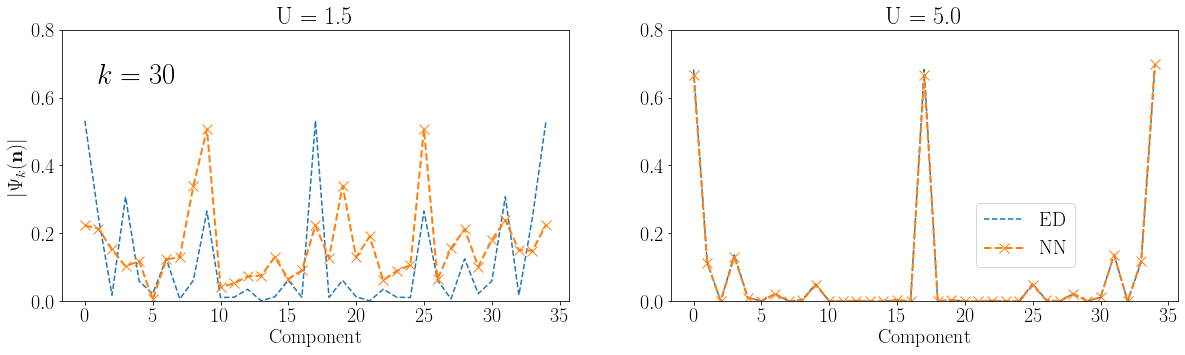

In [38]:
# check wavefunctions 
all_states = np.zeros_like(model.all_states)
idx_list = np.zeros(model.tot_states,dtype=int)

for i in range(int(model.tot_states/2)): 
    all_states[i] = model.all_states[i]
    all_states[-i-1] = np.flip(model.all_states[i])
    idx_list[i] = i
    for j in range(model.tot_states):
        if all(model.all_states[j]==all_states[-i-1]): 
            idx_list[-i-1] = j
            break


U_test = [1.5,5]
mu_test = np.zeros(len(U_test))
vals_all = np.zeros((model.tot_states, len(U_test)))
vals_idx_all = np.zeros_like(vals_all)
vecs_all = np.zeros((model.tot_states, model.tot_states, len(U_test)))

for (i,U) in enumerate(U_test):
    
    _, _, H = model.H_Bose_Hubbard(t, U, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx_all[:,i] = np.argsort(vals)
    vals_all[:,i] = vals
    vecs_all[:,:,i] = vecs

E_test, wf_test = wf_e_calc(model_list[0], N_list[0], U_test, mu_test, t, V, n_excited, load_states_indv, fc_gs, fc1=fc1, fc2=fc2, use_gpu=True)

ymax = [0.3,0.5,0.8]
for j,s in enumerate([4,15,30]): 
    print(s)
    fig, ax = plt.subplots(1, len(U_test), figsize=(20, 5))
    
    ymin = 0
    
    for (i,U) in enumerate(U_test):
    
        wf_here = wf_test[i*model.tot_states:(i+1)*model.tot_states,s].squeeze().double()
        wf_ed = np.abs(vecs_all[:,int(vals_idx_all[s, i]), i]).squeeze()
        wf_nn = np.abs(wf_here.cpu().detach().numpy())
        ax[i].plot(wf_ed[idx_list], '--',label="ED")
        ax[i].plot(wf_nn[idx_list], 'x--', lw=2, markersize=10,label="NN")
        
        ax[i].set_title("U = {0:.1f}".format(U))
        ax[i].set_ylim((ymin,ymax[j]))
        ax[i].set_xlabel('Component')
    if j == 2: 
        ax[1].legend(loc='best',bbox_to_anchor=(0.5, 0., 0.4, 0.4))
    
    ax[0].set_ylabel('$|\Psi_k (\mathbf{n})|$')
    ax[0].text(1, ymax[j]*0.8, '$k={}$'.format(s), fontsize='x-large')
    

    # plt.legend(frameon=False)
    plt.savefig("/content/drive/MyDrive/DNN/figures/wf_M{}N{}_n{}_nexcited_{}.pdf".format(M,N,s,n_excited), format='pdf')
    plt.show()
    


